In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt
from datetime import datetime, timezone

In [3]:
split_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
p_train = pd.read_csv(os.path.join(split_dir, 'p.train.csv'))
s_train = pd.read_csv(os.path.join(split_dir, 's.train.csv'))
p_test = pd.read_csv(os.path.join(split_dir, 'p.test.csv'))
s_test = pd.read_csv(os.path.join(split_dir, 's.test.csv'))
p_heldout = pd.read_csv(os.path.join(split_dir, 'p.20230101.csv'))
s_heldout = pd.read_csv(os.path.join(split_dir, 's.20230101.csv'))
p_stats = pd.read_csv(os.path.join(split_dir, 'p.station.ex.counts.csv'))
s_stats = pd.read_csv(os.path.join(split_dir, 's.station.ex.counts.csv'))

In [4]:
datadir = '../../data'
station_df = pd.read_csv(os.path.join(datadir, 'stat.info.csv'))
arr_cat = pd.read_csv(os.path.join(datadir, 'catalogs', 'yellowstone.arrivals.gains.2024.csv'))
ev_cat = pd.read_csv(os.path.join(datadir, 'catalogs', 'yellowstone.events.2024.csv'))

In [5]:
ev_cat.shape

(21075, 9)

In [6]:
# Remove WY.YNB because it didn't start up until 9/2023
station_df = station_df.drop(station_df[station_df.station == 'YNB'].index, axis=0)
station_df[station_df.station == 'YNB']

,network,station,receiver_lat,receiver_lon


In [7]:
# Read in park and caldera boundaries
ys_border = pd.read_csv(os.path.join(datadir, 'utahnet', 'yell.border.g'), delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(os.path.join(datadir, 'utahnet', 'caldera.ys'), sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1
caldera.head()

,Longitude,Latitude
0,-110.6149,44.7057
1,-110.6154,44.7040
2,-110.6158,44.7023
3,-110.6162,44.7003
4,-110.6158,44.6986


In [8]:
ev_cat[['event_lat', 'event_lon']].describe()

,event_lat,event_lon
count,21075.000000,21075.000000
mean,44.654390,-110.806796
std,0.163752,0.258270
min,44.000167,-111.331667
25%,44.568333,-111.014167
50%,44.739167,-110.813667
75%,44.777833,-110.673167
max,45.129000,-109.753333


In [9]:
# Filter stations to those used kept for training and merge the station location information
p_stats = p_stats[p_stats['station'].isin(p_train['station'].unique())].merge(station_df, on='station', how='left')
s_stats = s_stats[s_stats['station'].isin(s_train['station'].unique())].merge(station_df, on='station', how='left')
print(p_stats.shape[0], s_stats.shape[0])
p_stats.head()

35 18


,station,cnt_train,cnt_test,cnt_holdout,network,receiver_lat,receiver_lon
0,YHH,4813,1215.0,397.0,WY,44.78833,-110.85050
1,YNR,4649,1174.0,275.0,WY,44.71550,-110.67917
2,YMC,4322,1110.0,460.0,WY,44.75933,-111.00616
3,YMR,4154,1071.0,446.0,WY,44.66867,-110.96500
4,YPM,4078,1018.0,438.0,WY,44.65717,-110.86867


In [10]:
p_stats

,station,cnt_train,cnt_test,cnt_holdout,network,receiver_lat,receiver_lon
0,YHH,4813,1215.0,397.0,WY,44.788330,-110.850500
1,YNR,4649,1174.0,275.0,WY,44.715500,-110.679170
2,YMC,4322,1110.0,460.0,WY,44.759330,-111.006160
3,YMR,4154,1071.0,446.0,WY,44.668670,-110.965000
4,YPM,4078,1018.0,438.0,WY,44.657170,-110.868670
5,YWB,3780,913.0,357.0,WY,44.605830,-111.100830
6,YHB,3580,897.0,363.0,WY,44.750800,-111.196200
7,YFT,3529,920.0,293.0,WY,44.451330,-110.835830
8,MCID,3389,832.0,311.0,WY,44.190330,-111.182660
9,YHL,3213,812.0,374.0,WY,44.850900,-111.183000


In [11]:
p_stats[p_stats.station.isin(["YNE", 'YSB', 'YPK'])]

,station,cnt_train,cnt_test,cnt_holdout,network,receiver_lat,receiver_lon
30,YPK,371,89.0,59.0,WY,44.7318,-109.921933
33,YNE,345,94.0,68.0,WY,45.0076,-110.008000
34,YSB,324,79.0,21.0,WY,44.8840,-110.151000


In [12]:
p_stats[p_stats.cnt_train > 400].shape

(30, 7)

In [13]:
p_train.columns

Index(['event_identifier', 'arrival_identifier', 'network', 'station',
       'channel', 'location_code', 'source_latitude', 'source_longitude',
       'source_receiver_distance_km', 'source_receiver_back_azimuth',
       'source_depth_km', 'noise_variance', 'noise_minimum_value',
       'noise_maximum_value', 'signal_variance', 'signal_minimum_value',
       'signal_maximum_value', 'noise_dominant_frequency',
       'noise_dominant_amplitude', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'magnitude_type', 'magnitude',
       'avg_noise_1.00', 'avg_signal_1.00', 'avg_noise_2.00',
       'avg_signal_2.00', 'avg_noise_3.00', 'avg_signal_3.00',
       'avg_noise_4.00', 'avg_signal_4.00', 'avg_noise_5.00',
       'avg_signal_5.00', 'avg_noise_6.00', 'avg_signal_6.00',
       'avg_noise_7.00', 'avg_signal_7.00', 'avg_noise_8.00',
       'avg_signal_8.00', 'avg_noise_9.00', 'avg_signal_9.00',
       'avg_noise_10.00', 'avg_signal_10.00', 'avg_noise_11.00',
       'avg_sig

In [14]:
p_train_ev = p_train[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
s_train_ev = s_train[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
p_test_ev = p_test[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
s_test_ev = s_test[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
p_heldout_ev = p_heldout[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
s_heldout_ev = s_heldout[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
print(p_train_ev.shape[0], s_train_ev.shape[0])
print(p_test_ev.shape[0], s_test_ev.shape[0])
print(p_heldout_ev.shape[0], s_heldout_ev.shape[0])

5989 5170
1498 1312
508 436


In [15]:
station_df[station_df.station == 'YNB']

,network,station,receiver_lat,receiver_lon


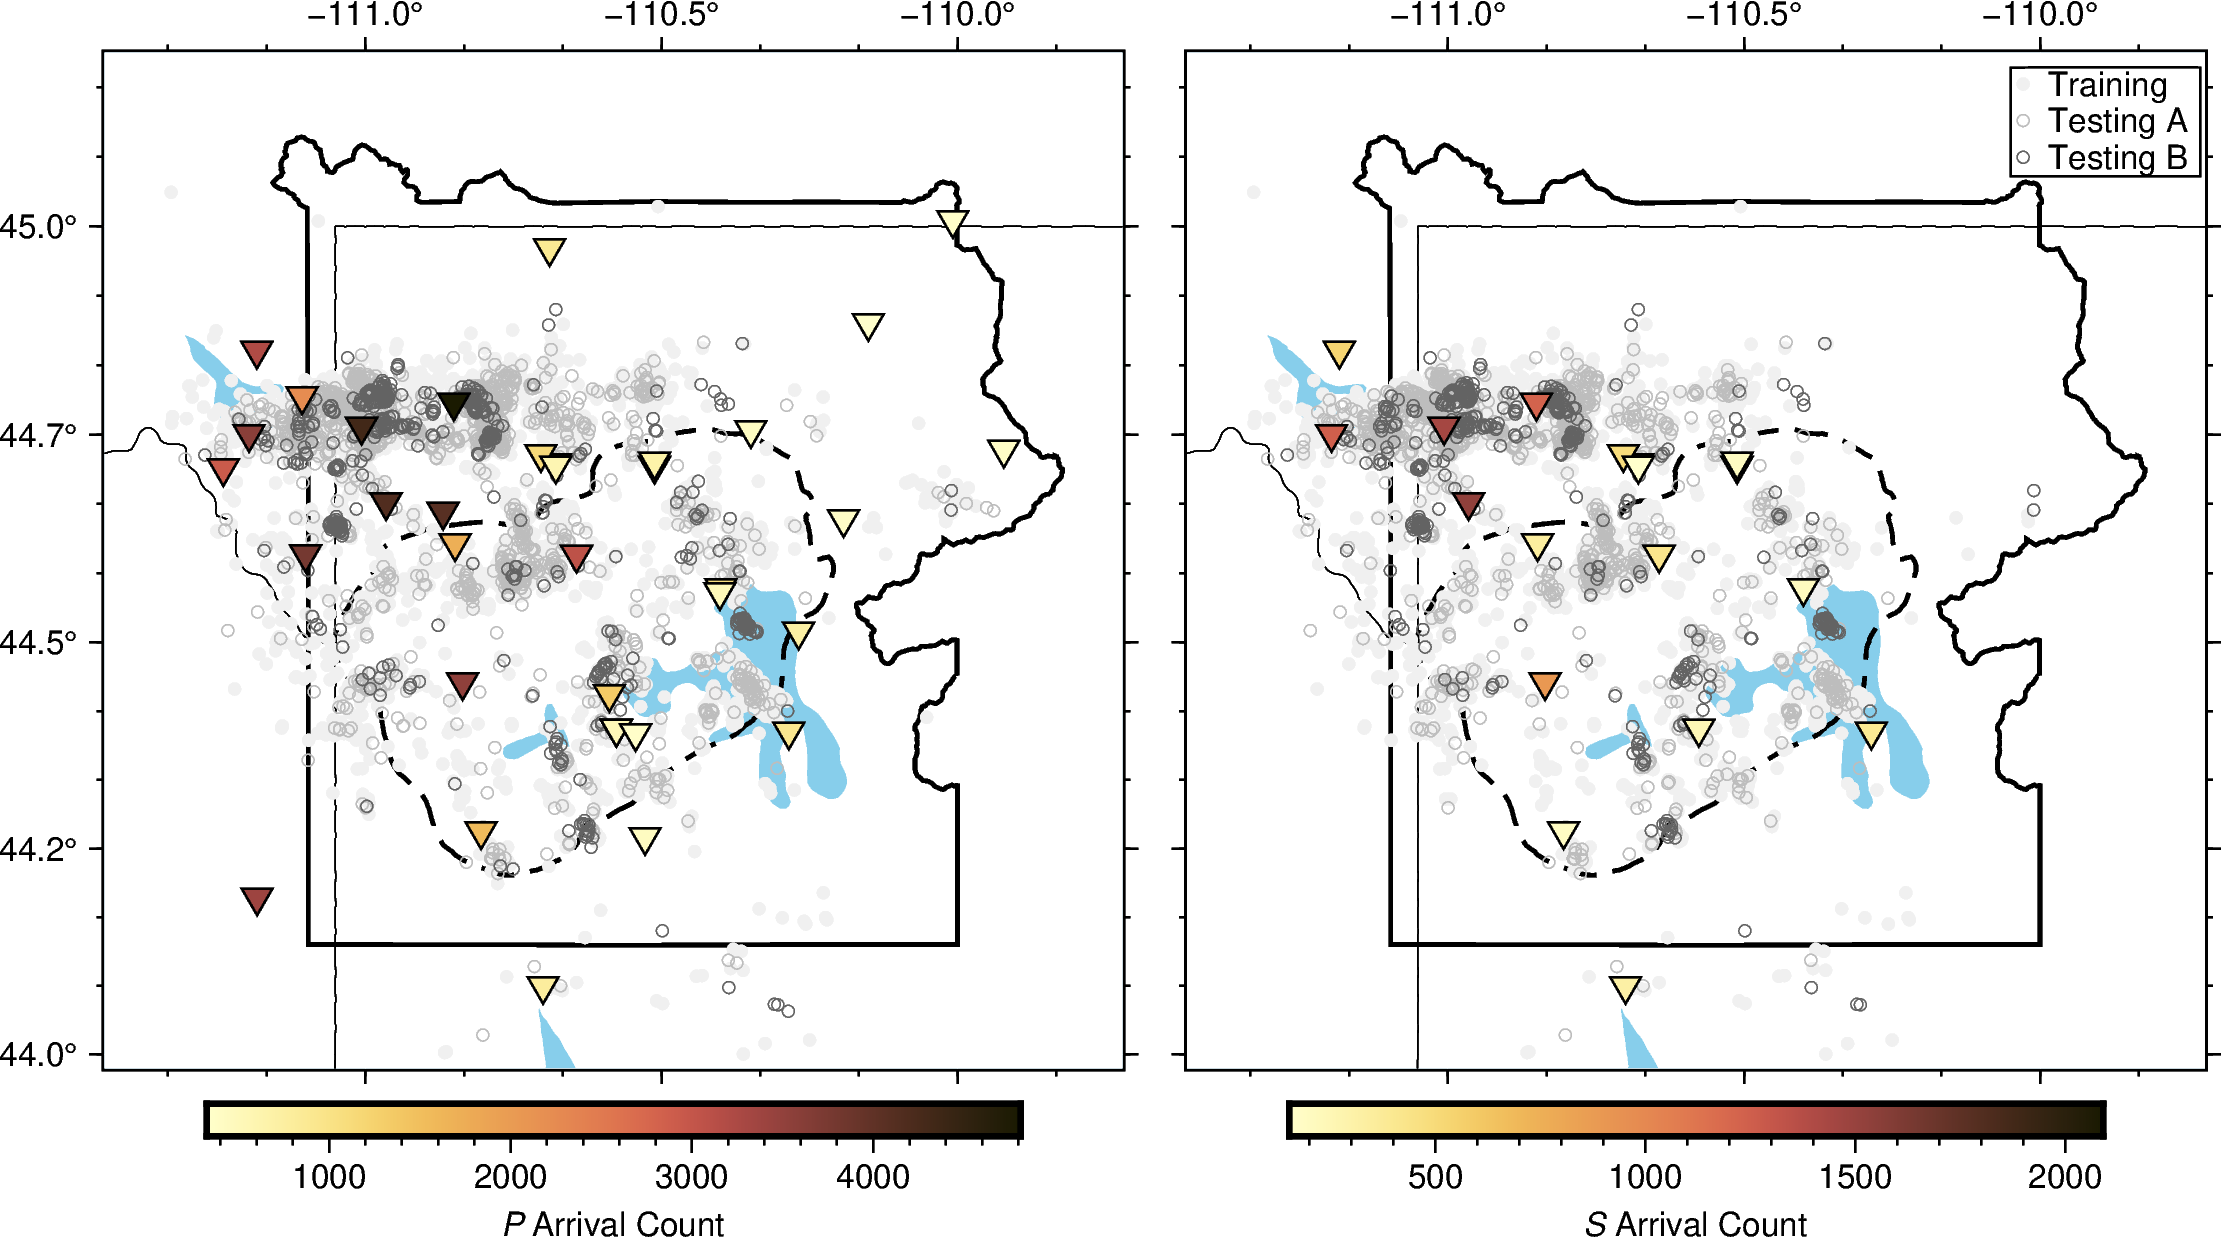

In [16]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT='8p', FONT_ANNOT_PRIMARY='8p')

region = [
    p_stats.receiver_lon.min() - 0.2,
    p_stats.receiver_lon.max() + 0.2,
    p_stats.receiver_lat.min() - 0.1,
    p_stats.receiver_lat.max() + 0.2,
]

with fig.subplot(ncols=2, figsize=("7i", "4i"), sharey='l', sharex='t'):
    with fig.set_panel(panel=0):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")
        pygmt.makecpt(cmap="lajolla", series=[p_stats.cnt_train.min(), p_stats.cnt_train.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        #fig.plot(data=p_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=p_train_ev[["source_longitude", "source_latitude"]], style="c0.1c", pen="0.25p,#f0f0f0", fill='#f0f0f0')
        fig.plot(data=p_test_ev[["source_longitude", "source_latitude"]], style="c0.1c", pen="0.25p,#bdbdbd")
        fig.plot(data=p_heldout_ev[["source_longitude", "source_latitude"]], style="c0.1c", pen="0.25p,#636363")
                 
        fig.plot(x=p_stats.receiver_lon, y=p_stats.receiver_lat,
        style="i0.3c", fill=p_stats.cnt_train, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"@%Helvetica-Oblique%P@%% Arrival Count"')
    with fig.set_panel(panel=1):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")

        pygmt.makecpt(cmap="lajolla", series=[s_stats.cnt_train.min(), s_stats.cnt_train.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        #fig.plot(data=s_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=s_train_ev[["source_longitude", "source_latitude"]], style="c0.1c", pen="0.25p,#f0f0f0", fill='#f0f0f0', label='Training')
        fig.plot(data=s_test_ev[["source_longitude", "source_latitude"]], style="c0.1c", pen="0.25p,#bdbdbd", label='Testing A')
        fig.plot(data=s_heldout_ev[["source_longitude", "source_latitude"]], style="c0.1c", pen="0.25p,#636363", label='Testing B')
        fig.plot(x=s_stats.receiver_lon, y=s_stats.receiver_lat,
                 style="i0.3c", fill=s_stats.cnt_train, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"@%Helvetica-Oblique%S@%% Arrival Count"') # @%Times-Italic%
        # box is broken for some reason
        fig.legend(box=False, position='jTR+o-0c/0.75c')
        fig.plot([[-110.05, 45.19], [-109.73, 45.19], [-109.73, 45.06], [-110.05, 45.06], [-110.05, 45.19]], pen='0.5p,black')
fig.show()
#fig.savefig('../../figures/side_by_side_station_counts_gray.png', dpi=300)

In [17]:
ps_merge_ev = p_train_ev.merge(s_train_ev, how='outer', on='event_identifier', indicator=True, suffixes=('_p', '_s'))
ps_merge_ev.head()

,event_identifier,source_latitude_p,source_longitude_p,source_depth_km_p,source_latitude_s,source_longitude_s,source_depth_km_s,_merge
0,60000622,44.764500,-111.088000,7.69,44.764500,-111.088000,7.69,both
1,60001352,44.389333,-111.035833,14.30,44.389333,-111.035833,14.30,both
2,60001367,44.406333,-111.053833,10.32,44.406333,-111.053833,10.32,both
3,60001387,44.399000,-111.044500,15.82,44.399000,-111.044500,15.82,both
4,60001392,44.393667,-111.051833,15.91,NaN,NaN,NaN,left_only


In [18]:
ps_merge_ev[ps_merge_ev['_merge'] == 'right_only']

,event_identifier,source_latitude_p,source_longitude_p,source_depth_km_p,source_latitude_s,source_longitude_s,source_depth_km_s,_merge
5989,60376027,NaN,NaN,NaN,44.777667,-111.125667,7.89,right_only


In [19]:
ev_cat[ev_cat['evid'] == 60376027]

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
14360,60376027,44.777667,-111.125667,7.89,1.586276e+09,0.88,l,F,2020-04-07 16:11:42.040001+00:00


In [20]:
ev_cat[ev_cat['magnitude_type'] == 'l'][~ev_cat[ev_cat['magnitude_type'] == 'l']['evid'].isin(ps_merge_ev['event_identifier'])]

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
48,60000620,44.474500,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00
66,60000940,44.479000,-110.591167,2.20,1.362430e+09,1.12,l,F,2013-03-04 20:50:17.969999+00:00
67,60000950,44.473500,-110.573333,-2.76,1.362431e+09,2.04,l,F,2013-03-04 21:02:42.149998+00:00
68,60000955,44.471833,-110.571000,4.69,1.362431e+09,2.06,l,F,2013-03-04 21:02:56.459999+00:00
75,60001055,44.323667,-110.683333,5.11,1.366107e+09,1.37,l,F,2013-04-16 10:03:41.809998+00:00
...,...,...,...,...,...,...,...,...,...
21047,60556637,44.448000,-110.551167,4.50,1.702787e+09,1.60,l,F,2023-12-17 04:29:21.150000+00:00
21048,60556642,44.417833,-110.569333,6.12,1.702787e+09,1.72,l,F,2023-12-17 04:31:38.209999+00:00
21051,60556657,44.744000,-111.175833,9.30,1.702817e+09,0.97,l,F,2023-12-17 12:51:07.870000+00:00
21052,60556662,44.747333,-111.170500,9.17,1.702818e+09,1.12,l,F,2023-12-17 13:07:27.090000+00:00


In [21]:
ps_merge_stats = p_stats.merge(s_stats, on='station',how='outer',indicator=True, suffixes=('_p', '_s') )

In [22]:
ps_merge_stats[ps_merge_stats['_merge']=='both']#[['receiver_lon_p', 'receiver_lat_p']]

,station,cnt_train_p,cnt_test_p,cnt_holdout_p,network_p,receiver_lat_p,receiver_lon_p,cnt_train_s,cnt_test_s,cnt_holdout_s,network_s,receiver_lat_s,receiver_lon_s,_merge
0,YHH,4813,1215.0,397.0,WY,44.788330,-110.850500,1222.0,328.0,113.0,WY,44.788330,-110.850500,both
1,YNR,4649,1174.0,275.0,WY,44.715500,-110.679170,2090.0,541.0,99.0,WY,44.715500,-110.679170,both
2,YMC,4322,1110.0,460.0,WY,44.759330,-111.006160,1443.0,363.0,171.0,WY,44.759330,-111.006160,both
3,YMR,4154,1071.0,446.0,WY,44.668670,-110.965000,1533.0,392.0,172.0,WY,44.668670,-110.965000,both
6,YHB,3580,897.0,363.0,WY,44.750800,-111.196200,1248.0,331.0,225.0,WY,44.750800,-111.196200,both
7,YFT,3529,920.0,293.0,WY,44.451330,-110.835830,899.0,214.0,55.0,WY,44.451330,-110.835830,both
9,YHL,3213,812.0,374.0,WY,44.850900,-111.183000,537.0,133.0,39.0,WY,44.850900,-111.183000,both
10,YML,3077,801.0,387.0,WY,44.605330,-110.643170,423.0,126.0,7.0,WY,44.605330,-110.643170,both
13,B207,1718,411.0,NaN,PB,44.619000,-110.848500,341.0,83.0,NaN,PB,44.619000,-110.848500,both
14,YUF,1676,463.0,225.0,WY,44.712600,-110.511700,816.0,227.0,118.0,WY,44.712600,-110.511700,both


In [23]:
stats_with_corrections = ['BUT', 'AHID', 'BOZ', 'BW06', 'LKWY', 'YFT', 'YHB', 'YMR', 'YNR', 'YUF']
james_stat_corrections = ['LOHW', 'REDW', 'YEE', 'YHH', 'YHL', 'YHR', 'YMP', 'YNE', 'YPP', 'YTP']

In [24]:
station_df['station'].isin(stats_with_corrections)*1

0     0
1     0
2     1
3     1
4     0
     ..
64    0
65    0
66    0
67    0
68    0
Name: station, Length: 68, dtype: int64

In [25]:
station_df[station_df['network'] == 'PB']

,network,station,receiver_lat,receiver_lon
4,PB,B207,44.6190,-110.8485
9,PB,B944,44.3897,-110.5438
13,PB,B208,44.5602,-110.4015
20,PB,B206,44.7177,-110.5117
35,PB,B945,44.8940,-110.7441
47,PB,B950,44.7128,-110.6785


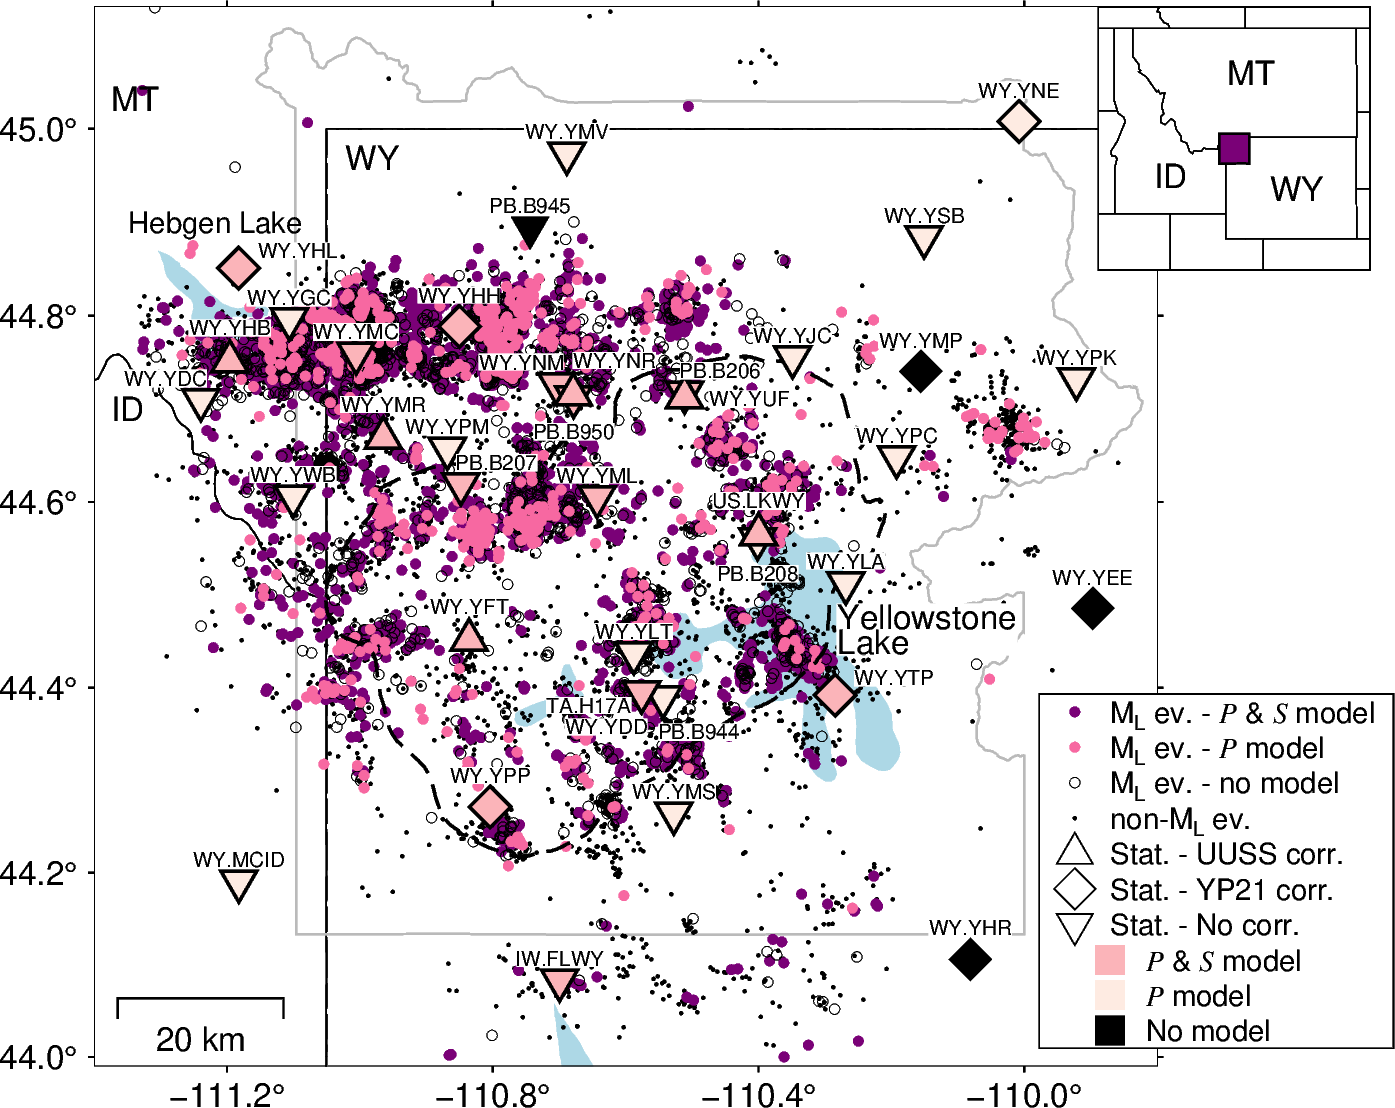

In [26]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p", FONT_ANNOT_PRIMARY='8p')

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4", "ya0.2"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
# fig.plot(data=caldera, pen='0.75p,#bababa,-')
fig.plot(data=ys_border, pen='0.5p,#bababa')
#fig.plot(data=uuss_auth_box, pen='0.5p,gray,-')

#
# Plot events
#
fig.plot(data=ev_cat[ev_cat['magnitude_type'] != 'l'][['event_lon', 'event_lat']], style='c1.0p', fill='black')
fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='both'][["source_longitude_p", "source_latitude_p"]], style="c2.5p", fill="#7a0177")
fig.plot(data=ev_cat[ev_cat['magnitude_type'] == 'l'][~ev_cat[ev_cat['magnitude_type'] == 'l']['evid'].isin(ps_merge_ev['event_identifier'])][['event_lon', 'event_lat']],
         style='c2.5p', 
         pen='0.1p,black')
fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='left_only'][["source_longitude_p", "source_latitude_p"]], style="c2.5p", fill="#f768a1")

##fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='right_only'][["source_longitude_s", "source_latitude_s"]], style="c0.75p", fill="blue")

#
# State labels, title, etc
#
fig.plot(data=caldera, pen='0.75p,black,-')#bababa

fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

# fig.text(x=-111.25, y=44.88, text="Hebgen Lake", justify="CM", angle=-42, offset='-0.05c/-0.05c')
# fig.text(x=-110.2, y=44.40, text="Yellowstone Lake", justify="RM", angle=-73, offset='0.20c/-0.35c', fill='white')
fig.text(x=-111.2, y=44.9, text="Hebgen Lake", justify="CM", offset="-0.1/-0.00", font='7p,Helvetica')
with open('ysl.txt', 'w') as fp:
    fp.write('''\
> -110.15 44.45 6p 0.1i l
Yellowstone Lake
''')
fig.text(textfiles='ysl.txt', M=True, offset='0.02c/0.1c', fill='white', clearance='0.2p')

#
#Plot stations
#
t_size = 0.35
stat_sym = ['i', 't']
stat_ec = ['black', 'black']
p_s_stat_color = "#fbb4b9"
p_stat_color = "#feebe2"
for i in range(2):
    s_df = station_df[station_df['station'].isin(stats_with_corrections) == i]
    ps_m_df = ps_merge_stats[ps_merge_stats.station.isin(stats_with_corrections) == i]
    if i == 0:
        s_j_df = s_df[s_df['station'].isin(james_stat_corrections)]
        ps_j_m_df = ps_m_df[ps_m_df['station'].isin(james_stat_corrections)]
        s_df = s_df[~s_df['station'].isin(james_stat_corrections)]
        ps_m_df = ps_m_df[~ps_m_df['station'].isin(james_stat_corrections)]
        
        fig.plot(data=s_j_df[~s_j_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'd{t_size}c', fill='black', pen=f'0.3p,{stat_ec[i]}')
        if 'left_only' in ps_j_m_df['_merge'].unique():
            fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill=p_stat_color, pen=f'0.75p,{stat_ec[i]}')
        fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill=p_s_stat_color, pen=f'0.75p,{stat_ec[i]}')

    fig.plot(data=s_df[~s_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'{stat_sym[i]}{t_size}c', fill='black', pen=f'0.3p,{stat_ec[i]}')
    if 'left_only' in ps_m_df['_merge'].unique():
        fig.plot(data=ps_m_df[ps_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill=p_stat_color, pen=f'0.75p,{stat_ec[i]}')
    fig.plot(data=ps_m_df[ps_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill=p_s_stat_color, pen=f'0.75p,{stat_ec[i]}')

for i, stat_row in station_df.iterrows():
    ud_offset = 0.185
    lr_offset = 0.0
    stat = stat_row['station']
    if stat in ['YDC', 'YDD', 'YNM']:
        lr_offset += -0.3
    elif stat in ['B207', 'B206', 'B944']:
        lr_offset += 0.3
    elif stat in ['YHL', 'YTP']:
        lr_offset += 0.5
    elif stat in ['YUF']:
        lr_offset += 0.55
    elif stat in ['H17A']:
        lr_offset += -0.45
    elif stat in ['YNR']:
        lr_offset += 0.35
    elif stat in ['QLMT']:
        lr_offset += 0.1

    if stat in ['YHL', 'YTP' ]:
        ud_offset += -0.04
    elif stat in ['YUF']:
        ud_offset += -0.2
    elif stat in ['H17A']:
        ud_offset += -0.3
    elif stat in ['B950', 'B208', 'B944', 'YDD']:
        ud_offset += -0.48
    elif stat in stats_with_corrections:
        ud_offset += 0.1
    elif stat in james_stat_corrections:
        ud_offset += 0.08

    fig.text(x=stat_row['receiver_lon'], 
             y=stat_row['receiver_lat'], 
             text=f"{stat_row['network']}.{stat}",
             font='5p,Helvetica',
             offset=f'{lr_offset}c/{ud_offset}c',
             fill="white", 
             clearance="0.2p")

#
# Plot map insert
#
with fig.inset(position="jTR+o-1.8c/0.0c+w2.3c/2.23c", box="+p0.3,black+gwhite"):
    fig.coast(
        region = STUDYREG + np.array([-6.5, 6.5, -4.25, 4.6]),
        projection = f"M5.4/9/?",
        borders = [1, 2]
    )
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(frame=["nsew"])
        
    fig.plot(data=[[STUDYREG[0], STUDYREG[2], STUDYREG[1], STUDYREG[3]]], style="r+s", fill="#7a0177", pen="0.5p,black")

    fig.text(
        x = -107.25, 
        y = 43,
        text = "WY",
    )
    fig.text(
        x = -114, 
        y = 43.5, 
        text = "ID", 
    )
    fig.text(
        x = -109.7, 
        y = 47.4, 
        text = "MT", 
    )

#
# Plot legend
#
with fig.inset(position="jBR+o-2.0/0.15", 
               box="+p0.3,black+gwhite",
               region=[-1, 1, -1, 1], projection='X3c'):

        text_x = -0.6
        sym_x = -0.8
        # Dark, filled circle
        y = 0.9
        fig.plot(data=[[sym_x, y]], 
                style="c2.5p", 
                fill="#7a0177")
        fig.text(x=text_x, y=y, text='M@-L@- ev. - @%Times-Italic%P@%% & @%Times-Italic%S@%% model', justify='ML', font='7p,Helvetica')

        # # Light, filled circle
        y -= 0.2
        fig.plot(data=[[sym_x, y]],
                style="c2.5p",
                fill="#f768a1")
        fig.text(x=text_x, y=y, text='M@-L@- ev. - @%Times-Italic%P@%% model', justify='ML', font='7p,Helvetica')

        # # Open circle
        y -= 0.2
        fig.plot(data=[[sym_x, y]],
                style='c2.5p', 
                pen='0.1p,black')  
        fig.text(x=text_x, y=y, text='M@-L@- ev. - no model', justify='ML', font='7p,Helvetica')

        # # dark point
        y -= 0.2
        fig.plot(data=[[sym_x, y]],
                style='c1.0p', 
                fill='black')
        fig.text(x=text_x, y=y, text='non-M@-L@- ev.', justify='ML', font='7p,Helvetica')

        # Triangle
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f't{t_size}c', 
                fill='white', 
                pen=f'0.3p,black') 
        fig.text(x=text_x, y=y, text='Stat. - UUSS corr.', justify='ML', font='7p,Helvetica')
      
        # Diamond
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'd{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')  
        fig.text(x=text_x, y=y, text='Stat. - YP21 corr.', justify='ML', font='7p,Helvetica')
            
        # Inverted Triangle 
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'i{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')   
        fig.text(x=text_x, y=y, text='Stat. - No corr.', justify='ML', font='7p,Helvetica')

        # Mid fill
        # P & S fill='#feebe2'
        y -= 0.2
        sym_x += 0.2
        text_x += 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill=p_s_stat_color)     
        fig.text(x=text_x, y=y, text='@%Times-Italic%P@%% & @%Times-Italic%S@%% model', justify='ML', font='7p,Helvetica')

        # Light fill
        # Just P fill='#fbb4b9'
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill=p_stat_color)   
        fig.text(x=text_x, y=y, text='@%Times-Italic%P@%% model', justify='ML', font='7p,Helvetica')
  
        # Black fill
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill='black')  
        fig.text(x=text_x, y=y, text='No model', justify='ML', font='7p,Helvetica')
         
fig.show()
#fig.savefig("../../figures/ys_map.png", dpi=300)
#fig.savefig("../../figures/ys_map_QLMT.png", dpi=300)

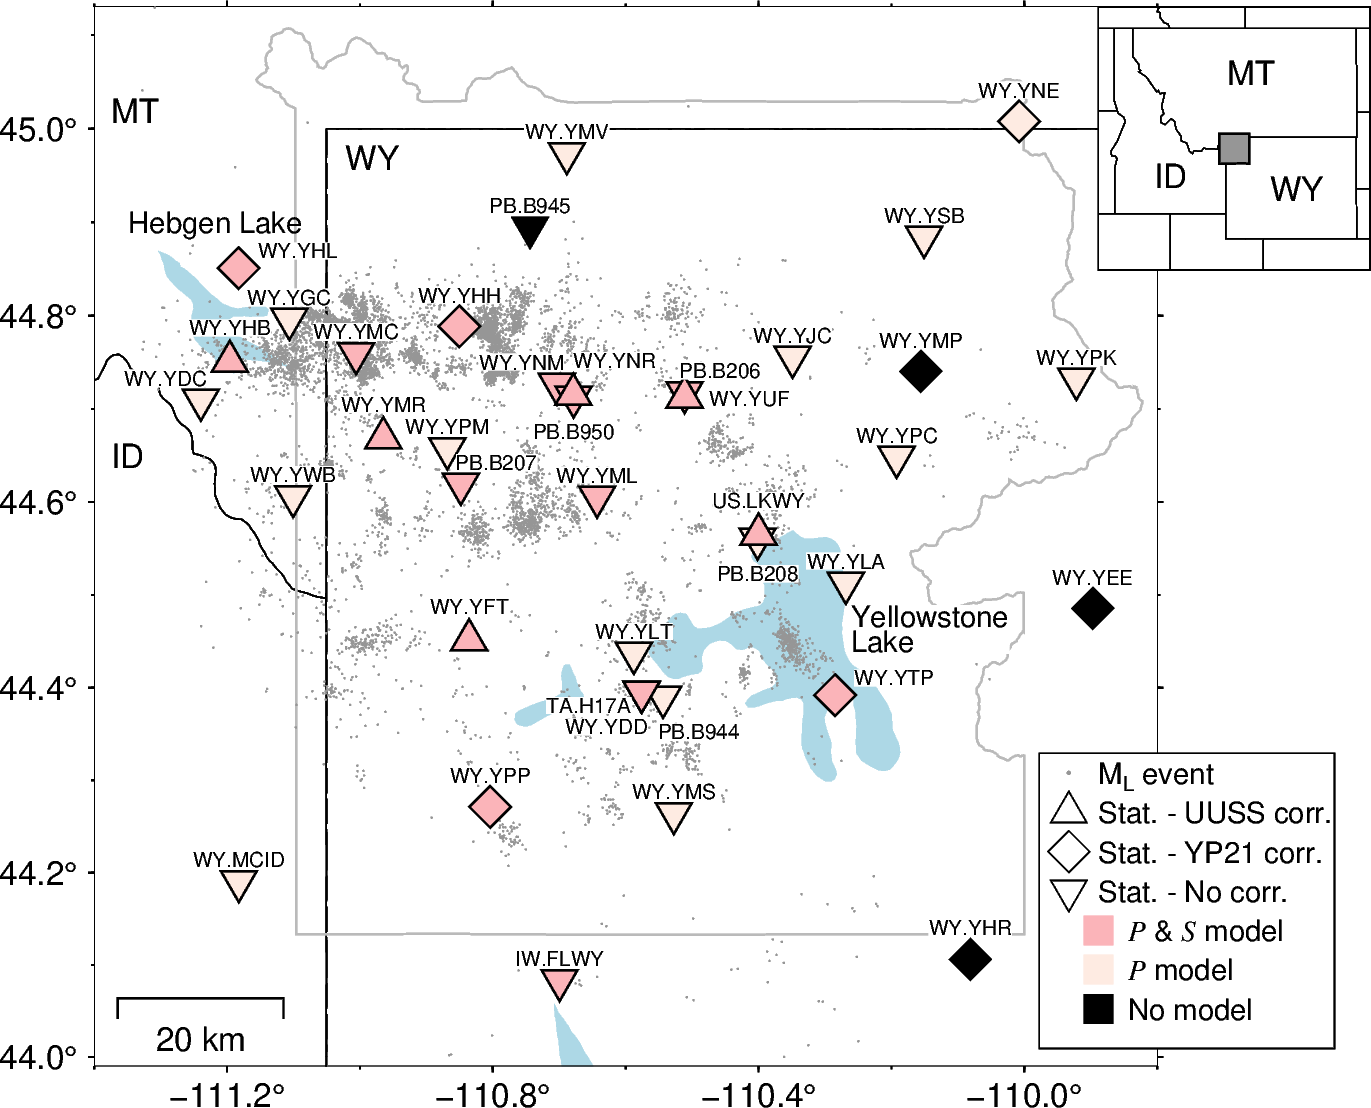

In [27]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p", FONT_ANNOT_PRIMARY='8p')

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4f0.2", "ya0.2f0.1"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
# fig.plot(data=caldera, pen='0.75p,#bababa,-')
fig.plot(data=ys_border, pen='0.5p,#bababa')
#fig.plot(data=uuss_auth_box, pen='0.5p,gray,-')

#
# Plot events
#
fig.plot(data=ev_cat[ev_cat['magnitude_type'] == 'l'][['event_lon', 'event_lat']], style='c0.5p', fill='#969696')

##fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='right_only'][["source_longitude_s", "source_latitude_s"]], style="c0.75p", fill="blue")

#
# State labels, title, etc
#
# fig.plot(data=caldera, pen='0.75p,black,-')#bababa

fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.15", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.65, text="ID", justify="LM")

# fig.text(x=-111.25, y=44.88, text="Hebgen Lake", justify="CM", angle=-42, offset='-0.05c/-0.05c')
# fig.text(x=-110.2, y=44.40, text="Yellowstone Lake", justify="RM", angle=-73, offset='0.20c/-0.35c', fill='white')
fig.text(x=-111.2, y=44.9, text="Hebgen Lake", justify="CM", offset="-0.1/-0.00", font='7p,Helvetica')
with open('ysl.txt', 'w') as fp:
    fp.write('''\
> -110.15 44.45 6p 0.1i l
Yellowstone Lake
''')
fig.text(textfiles='ysl.txt', M=True, offset='0.04c/0.1c', fill='white', clearance='0.2p', font='7p,Helvetica')

#
#Plot stations
#
t_size = 0.35
stat_sym = ['i', 't']
stat_ec = ['black', 'black']
p_s_stat_color = "#fbb4b9"
p_stat_color = "#feebe2"
for i in range(2):
    s_df = station_df[station_df['station'].isin(stats_with_corrections) == i]
    ps_m_df = ps_merge_stats[ps_merge_stats.station.isin(stats_with_corrections) == i]
    if i == 0:
        s_j_df = s_df[s_df['station'].isin(james_stat_corrections)]
        ps_j_m_df = ps_m_df[ps_m_df['station'].isin(james_stat_corrections)]
        s_df = s_df[~s_df['station'].isin(james_stat_corrections)]
        ps_m_df = ps_m_df[~ps_m_df['station'].isin(james_stat_corrections)]
        
        fig.plot(data=s_j_df[~s_j_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'd{t_size}c', fill='black', pen=f'0.3p,{stat_ec[i]}')
        if 'left_only' in ps_j_m_df['_merge'].unique():
            fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill=p_stat_color, pen=f'0.5p,{stat_ec[i]}')
        fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill=p_s_stat_color, pen=f'0.5p,{stat_ec[i]}')

    fig.plot(data=s_df[~s_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'{stat_sym[i]}{t_size}c', fill='black', pen=f'0.3p,{stat_ec[i]}')
    if 'left_only' in ps_m_df['_merge'].unique():
        fig.plot(data=ps_m_df[ps_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill=p_stat_color, pen=f'0.5p,{stat_ec[i]}')
    fig.plot(data=ps_m_df[ps_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill=p_s_stat_color, pen=f'0.5p,{stat_ec[i]}')

for i, stat_row in station_df.iterrows():
    ud_offset = 0.185
    lr_offset = 0.0
    stat = stat_row['station']
    if stat in ['YDC', 'YDD', 'YNM']:
        lr_offset += -0.3
    elif stat in ['B207', 'B206', 'B944']:
        lr_offset += 0.3
    elif stat in ['YHL', 'YTP']:
        lr_offset += 0.5
    elif stat in ['YUF']:
        lr_offset += 0.55
    elif stat in ['H17A']:
        lr_offset += -0.45
    elif stat in ['YNR']:
        lr_offset += 0.35
    elif stat in ['QLMT']:
        lr_offset += 0.1

    if stat in ['YHL', 'YTP' ]:
        ud_offset += -0.04
    elif stat in ['YUF']:
        ud_offset += -0.2
    elif stat in ['H17A']:
        ud_offset += -0.3
    elif stat in ['B950', 'B208', 'B944', 'YDD']:
        ud_offset += -0.48
    elif stat in stats_with_corrections:
        ud_offset += 0.1
    elif stat in james_stat_corrections:
        ud_offset += 0.08

    fig.text(x=stat_row['receiver_lon'], 
             y=stat_row['receiver_lat'], 
             text=f"{stat_row['network']}.{stat}",
             font='5p,Helvetica',
             offset=f'{lr_offset}c/{ud_offset}c',
             fill="white", 
             clearance="0.2p")

#
# Plot map insert
#
with fig.inset(position="jTR+o-1.8c/0.0c+w2.3c/2.23c", box="+p0.3,black+gwhite"):
    fig.coast(
        region = STUDYREG + np.array([-6.5, 6.5, -4.25, 4.6]),
        projection = f"M5.4/9/?",
        borders = [1, 2]
    )
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(frame=["nsew"])
        
    fig.plot(data=[[STUDYREG[0], STUDYREG[2], STUDYREG[1], STUDYREG[3]]], style="r+s", fill="#969696", pen="0.5p,black")

    fig.text(
        x = -107.25, 
        y = 43,
        text = "WY",
    )
    fig.text(
        x = -114, 
        y = 43.5, 
        text = "ID", 
    )
    fig.text(
        x = -109.7, 
        y = 47.4, 
        text = "MT", 
    )

#
# Plot legend
#
with fig.inset(position="jBR+o-1.5/0.15", 
               box="+p0.3,black+gwhite",
               region=[-1, 1, -0.5, 1], projection='X2.5c'):

        text_x = -0.6
        sym_x = -0.8
        # Dark, filled circle
        y = 0.9
        fig.plot(data=[[sym_x, y]], 
                style='c1.0p', 
                fill='#969696')
        fig.text(x=text_x, y=y, text='M@-L@- event', justify='ML', font='7p,Helvetica')

        # Triangle
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f't{t_size}c', 
                fill='white', 
                pen=f'0.3p,black') 
        fig.text(x=text_x, y=y, text='Stat. - UUSS corr.', justify='ML', font='7p,Helvetica')
      
        # Diamond
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'd{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')  
        fig.text(x=text_x, y=y, text='Stat. - YP21 corr.', justify='ML', font='7p,Helvetica')
            
        # Inverted Triangle 
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'i{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')   
        fig.text(x=text_x, y=y, text='Stat. - No corr.', justify='ML', font='7p,Helvetica')

        # Mid fill
        # P & S fill='#feebe2'
        y -= 0.2
        sym_x += 0.2
        text_x += 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill=p_s_stat_color)     
        fig.text(x=text_x, y=y, text='@%Times-Italic%P@%% & @%Times-Italic%S@%% model', justify='ML', font='7p,Helvetica')

        # Light fill
        # Just P fill='#fbb4b9'
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill=p_stat_color)   
        fig.text(x=text_x, y=y, text='@%Times-Italic%P@%% model', justify='ML', font='7p,Helvetica')
  
        # Black fill
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill='black')  
        fig.text(x=text_x, y=y, text='No model', justify='ML', font='7p,Helvetica')
         
fig.show()
#fig.savefig("../../figures/ys_map.png", dpi=300)
# fig.savefig("../../figures/ys_map_simple_nocaldera.png", dpi=300, resize='+m0.25c')
fig.savefig("../../figures/manuscript/figure1.jpg", dpi=300, resize='+m0.25c')

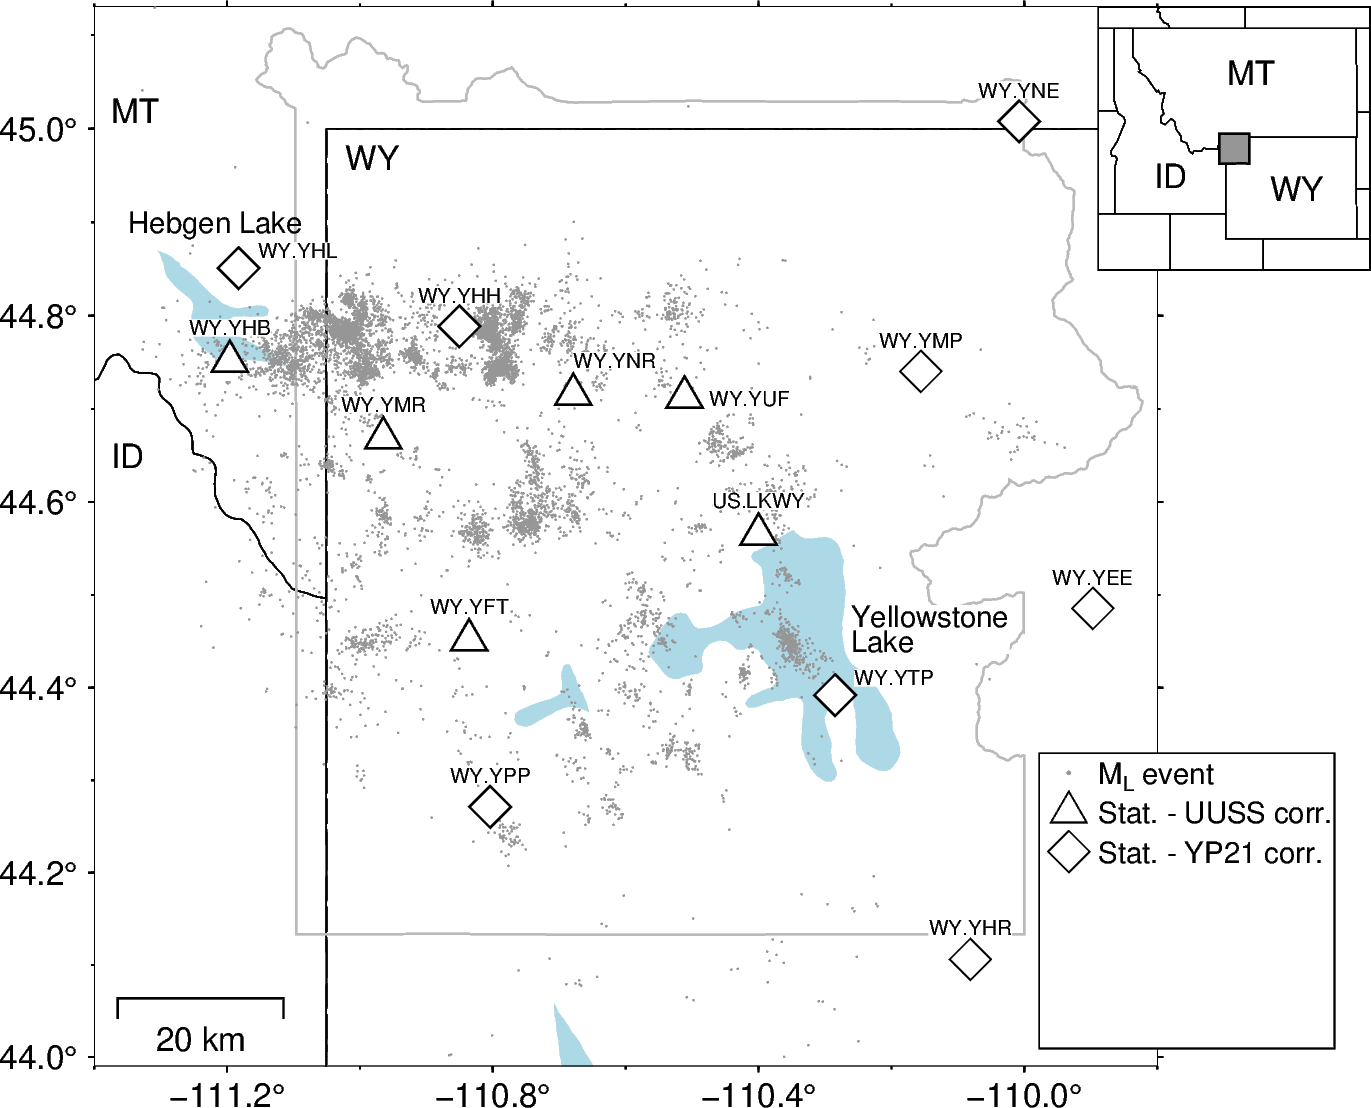

In [28]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p", FONT_ANNOT_PRIMARY='8p')

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
#STUDYREG = np.array([-111.50, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4f0.2", "ya0.2f0.1"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
# fig.plot(data=caldera, pen='0.75p,#bababa,-')
fig.plot(data=ys_border, pen='0.5p,#bababa')
#fig.plot(data=uuss_auth_box, pen='0.5p,gray,-')

#
# Plot events
#
fig.plot(data=ev_cat[ev_cat['magnitude_type'] == 'l'][['event_lon', 'event_lat']], style='c0.5p', fill='#969696')

##fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='right_only'][["source_longitude_s", "source_latitude_s"]], style="c0.75p", fill="blue")

#
# State labels, title, etc
#
# fig.plot(data=caldera, pen='0.75p,black,-')#bababa

fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.15", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.65, text="ID", justify="LM")

# fig.text(x=-111.25, y=44.88, text="Hebgen Lake", justify="CM", angle=-42, offset='-0.05c/-0.05c')
# fig.text(x=-110.2, y=44.40, text="Yellowstone Lake", justify="RM", angle=-73, offset='0.20c/-0.35c', fill='white')
fig.text(x=-111.2, y=44.9, text="Hebgen Lake", justify="CM", offset="-0.1/-0.00", font='7p,Helvetica')
with open('ysl.txt', 'w') as fp:
    fp.write('''\
> -110.15 44.45 6p 0.1i l
Yellowstone Lake
''')
fig.text(textfiles='ysl.txt', M=True, offset='0.04c/0.1c', fill='white', clearance='0.2p', font='7p,Helvetica')

#
#Plot stations
#
t_size = 0.35
stat_sym = ['i', 't']
stat_ec = ['black', 'black']
p_s_stat_color = "white"
p_stat_color = "white"
for i in range(2):
    s_df = station_df[station_df['station'].isin(stats_with_corrections) == i]
    ps_m_df = ps_merge_stats[ps_merge_stats.station.isin(stats_with_corrections) == i]
    if i == 0:
        s_j_df = s_df[s_df['station'].isin(james_stat_corrections)]
        ps_j_m_df = ps_m_df[ps_m_df['station'].isin(james_stat_corrections)]
        s_df = s_df[~s_df['station'].isin(james_stat_corrections)]
        ps_m_df = ps_m_df[~ps_m_df['station'].isin(james_stat_corrections)]
        
        fig.plot(data=s_j_df[~s_j_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'd{t_size}c', fill='white', pen=f'0.3p,{stat_ec[i]}')
        if 'left_only' in ps_j_m_df['_merge'].unique():
            fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill=p_stat_color, pen=f'0.5p,{stat_ec[i]}')
        fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill=p_s_stat_color, pen=f'0.5p,{stat_ec[i]}')
    else:
        fig.plot(data=s_df[~s_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'{stat_sym[i]}{t_size}c', fill='white', pen=f'0.3p,{stat_ec[i]}')
        if 'left_only' in ps_m_df['_merge'].unique():
            fig.plot(data=ps_m_df[ps_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill=p_stat_color, pen=f'0.5p,{stat_ec[i]}')
        fig.plot(data=ps_m_df[ps_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill=p_s_stat_color, pen=f'0.5p,{stat_ec[i]}')

for i, stat_row in station_df[(station_df['station'].isin(stats_with_corrections)) | (station_df['station'].isin(james_stat_corrections))].iterrows():
    ud_offset = 0.185
    lr_offset = 0.0
    stat = stat_row['station']
    if stat in ['YDC', 'YDD', 'YNM']:
        lr_offset += -0.3
    elif stat in ['B207', 'B206', 'B944']:
        lr_offset += 0.3
    elif stat in ['YHL', 'YTP']:
        lr_offset += 0.5
    elif stat in ['YUF']:
        lr_offset += 0.55
    elif stat in ['H17A']:
        lr_offset += -0.45
    elif stat in ['YNR']:
        lr_offset += 0.35
    elif stat in ['QLMT']:
        lr_offset += 0.1

    if stat in ['YHL', 'YTP' ]:
        ud_offset += -0.04
    elif stat in ['YUF']:
        ud_offset += -0.2
    elif stat in ['H17A']:
        ud_offset += -0.3
    elif stat in ['B950', 'B208', 'B944', 'YDD']:
        ud_offset += -0.48
    elif stat in stats_with_corrections:
        ud_offset += 0.1
    elif stat in james_stat_corrections:
        ud_offset += 0.08

    fig.text(x=stat_row['receiver_lon'], 
             y=stat_row['receiver_lat'], 
             text=f"{stat_row['network']}.{stat}",
             font='5p,Helvetica',
             offset=f'{lr_offset}c/{ud_offset}c',
             fill="white", 
             clearance="0.2p")

#
# Plot map insert
#
with fig.inset(position="jTR+o-1.8c/0.0c+w2.3c/2.23c", box="+p0.3,black+gwhite"):
    fig.coast(
        region = STUDYREG + np.array([-6.5, 6.5, -4.25, 4.6]),
        projection = f"M5.4/9/?",
        borders = [1, 2]
    )
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(frame=["nsew"])
        
    fig.plot(data=[[STUDYREG[0], STUDYREG[2], STUDYREG[1], STUDYREG[3]]], style="r+s", fill="#969696", pen="0.5p,black")

    fig.text(
        x = -107.25, 
        y = 43,
        text = "WY",
    )
    fig.text(
        x = -114, 
        y = 43.5, 
        text = "ID", 
    )
    fig.text(
        x = -109.7, 
        y = 47.4, 
        text = "MT", 
    )

#
# Plot legend
#
with fig.inset(position="jBR+o-1.5/0.15", 
               box="+p0.3,black+gwhite",
               region=[-1, 1, -0.5, 1], projection='X2.5c'):

        text_x = -0.6
        sym_x = -0.8
        # Dark, filled circle
        y = 0.9
        fig.plot(data=[[sym_x, y]], 
                style='c1.0p', 
                fill='#969696')
        fig.text(x=text_x, y=y, text='M@-L@- event', justify='ML', font='7p,Helvetica')

        # Triangle
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f't{t_size}c', 
                fill='white', 
                pen=f'0.3p,black') 
        fig.text(x=text_x, y=y, text='Stat. - UUSS corr.', justify='ML', font='7p,Helvetica')
      
        # Diamond
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'd{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')  
        fig.text(x=text_x, y=y, text='Stat. - YP21 corr.', justify='ML', font='7p,Helvetica')
         
fig.show()
#fig.savefig("../../figures/ys_map.png", dpi=300)
#fig.savefig("../../figures/ys_starcorr_map_simple_nocaldera.png", dpi=300)